# **Loss-based Sampling**

---
This notebook was created by Group 4 (Jolina Blume, Sara Günther, and Daria Ilyuchik) as part of the final project in the course 'Optimizing Experiment Design' in the Wintersemester 2024/25 at the University of Osnabrück.

Please note that many code parts were inspired by the course material and by Haimovich et al. (2024).

---

In this notebook, we will implement a loss-based prediction model based on Haimovich et al. (2024) and their proposed adaptive sampling method. In particular, we will implement a Random Forest (RF) Regressor for predicting the loss of the model with the task objective, here within the context of a two-alternative forced choice (2AFC) task. Afterwards, we will contrast it with a multi-layer perceptron (MLP) prediction model. Finally, we will compare these two loss-based sampling methods to a random sampling approach, specifically one following a uniform distribution.

The two prediction models will be integrated within the general AutoRA framework to set up the 2AFC task as an automated closed-loop experiment. In more detail, the loss prediction models will each be part of an experimentalist and will be used to estimate the loss. Based on this estimated loss new experimental conditions will then be sampled. These newly sampled conditions will then be run by the experimental runner, who i.e. generates experiment data within the context of a 2AFC task in this case.  As a theorist, we will use the feedforward neural network (FFN) Regressor implemented during the course.


# Experiment Description

The 2AFC experiment aims at examining the response times of participants in a choice task with two possible options. In each trial, a stimulus image is briefly displayed. The stimulus image consists of a grid of orange and blue tiles of different ratio and scatteredness. See below for an example of a stimulus.

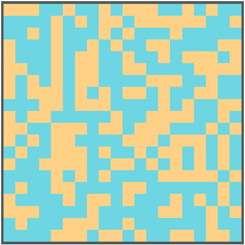

The experiment is thus manipulated by two factors: ratio and scatteredness. The ratio controls the balance of blue to orange tiles. A ratio of 0 means that only orange tiles are shown, whereas a value of 1 corresponds to an equal number of orange and blue tiles. The scatteredness governs the spatial arrangement of the tiles. A scatteredness value of 0 places all orange tiles exclusively on the left side of the grid, while a value of 1 results in a completely random distribution of tiles.


# Basic Set-up

When running this notebook, make sure that there is a folder called "resources" in your directory, or rather in your Google Colab files. This folder should include the files "regressors.py", "sampler.py", and "synthetic.py" from the block course.


In [ ]:
# comment in notebook is run for the first time to install the AutoRA library
!pip install autora

In [ ]:
# All necessary library imports
import numpy as np
import pandas as pd
import itertools

from resources.regressors import FFN, FFNRegressor
from resources.synthetic import twoafc
from resources.sampler import random_sampler

from autora.experiment_runner.synthetic.utilities import describe
from autora.variable import ValueType, VariableCollection
from autora.state import StandardState, on_state, estimator_on_state

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from typing import Optional, List

import matplotlib.pyplot as plt

In [ ]:
# Define basic experiment parameters:

n_units = 10 # number of participants
noise_level = 0.2

# set parameters for the participants -- those parameters are meant to capture individual differences (these are not the experimental conditions)
parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0, parameters)

# Experiment Runner

In [ ]:
# Instantiate the experiment:

experiment = twoafc(parameters)
print(describe(experiment))


    2AFC experiment with two independent variables

    Args:
        parameters: abstract participant parameters for the underlying ground truth model; must be an array of shape (n_units, 2)
        name: name of the experiment
        resolution: number of allowed values for stimulus
        Examples:
        >>> s = twoafc()
        >>> s.run(np.array([[.2,.1]]), random_state=42)
            participant id  ratio   scatteredness   response time
        0   0               1.0     1.0             1.592393
    


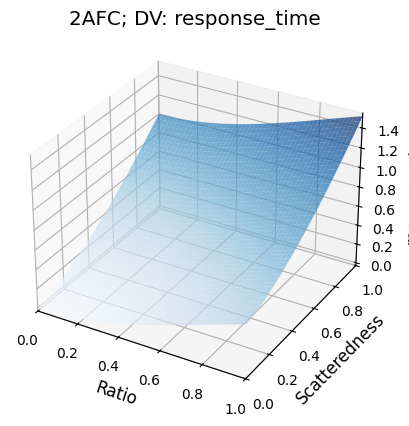

In [ ]:
# Run the experiment and plot the underlying ground truth:
# This will later on be used for evaluating the different sampling approaches

experiment.run(np.array([[0, 1, 1]]), random_state=42) # np.array: unit_id, ratio, scatteredness
experiment.plotter()

In [ ]:
# Define the tracking lists used for comparison later on:

# Loss-based sampling (RF):
n_samples_list = []
mean_train_loss_list = []
n_labeled_samples = 0
mse_list = []

# Loss-based sampling (MLP):
n_samples_list_mlp = []
mean_train_loss_list_mlp = []
mse_list_mlp = []

# Random sampling:
n_samples_list_random = []
mean_train_loss_list_random = []

Next, we initialise the two regressors which will later on be used for the two loss-based sampling strategies. As a side note, we choose one single hidden layer with a number of 8 nodes for our MLP Regressor based on the input layer containing 4 and the output layer containing 1 node. Further, we use the rectified linear unit function ReLu as our activation function for the hidden layer. We chose an optimizer in the family of quasi-Newton methods (i.e. Limited-memory Broyden-Fletcher-Goldfarb-Shanno LBFGS) as our solver for weight optimization, given that we are dealing with a relatively small dataset and that this solver in particular allows for faster convergence and better performance when dealing with little data.

In [ ]:
# Initialise the regressors (RF and MLP), which are later on used as the prediction model:

loss_predictor_rf = RandomForestRegressor(random_state=42)
loss_predictor_mlp = MLPRegressor(hidden_layer_sizes=(8,), activation='relu', solver='lbfgs', random_state=42)

## Loss-based Sampler Using RF Regressor

In the following, we are defining a function for the loss-based approach using the Random Forest (RF) Regressor. The loss_based_sampler_random_forest function trains a RF Regressor to predict the loss (using past, observed data), and finally uses the predicted loss to sample candidates probabilistically.

To do so, the function follows the following procedure:

1. We extract all necessary information from the state variable
2. We let the model with the task objective predict the observations given the experimental conditions, and calculate the training losses per sample.
3. We train our previously initialised RF Regressor and evaluate its performance on the training data.
4. We generate candidate samples using random sampling and, based on their estimated loss from the RF Regressor, either accept or reject them probabilistically until a specified number of samples has been selected -- these selected samples are then returned and will in the next step be made use of by the experiment runner as new experimental conditions to be run within the context of a closed-loop experiment. In doing so, the RF Regressor is fitted on the entire dataset (i.e. the past experimental conditions and current predictions as well as losses of the model with the task objective) in each cycle of the loop to improve its accuracy and robustness.

---

In the paper by Haimovich et al. (2024), the loss-based sampling approach was applied to classification tasks. To adapt this methodology to our 2AFC experiment, some adjustments were necessary to account for the different nature of our data and experimental design:


**Loss Evaluation Metric Adjustment**

In contrast to the approach of Haimovich et al. (2024) we opted to use the Mean Squared Error (MSE) for evaluating losses rather than the Cross Entropy Loss. The reason behing this modification is that Cross Entropy Loss is generally, and in the given paper, used to compute the loss for classification tasks dealing with probabilites between 0 and 1. Since our experiment involves reaction time values, which are continuous and not probabilistic, MSE serves as a more suitable metric.

**Loss Scaling Modification**

The original paper employed clipping of loss values, a strategy that works well for the employed classification tasks with probabilistic values. However, given that we are working with reaction times, direct clipping is less appropriate. Instead, we apply a min-max scaling procedure to adjust the loss values to a range between 0 and 1. This scaling is based on the previously sampled loss values, ensuring that each new loss is converted to a relative measure compared to historical data. After scaling, we still apply clipping to guarantee that the final values reamin within the interval between 0 and 1, avoiding the extreme boundaries.



In [ ]:
def loss_based_sampler_random_forest(state, num_samples, random_state=None, sample_all=[], experiment=experiment, loss_predictor=loss_predictor_rf):

    # Get the independent and dependent variables from the state
    variables = state.variables
    iv_names = [iv.name for iv in variables.independent_variables]
    dv_names = [dv.name for dv in variables.dependent_variables]
    epsilon = 1e-10 # define epsilon to be a small value which is later used to ensure no division by 0

    # Get the experimental conditions and true observations from the state
    train_X = state.experiment_data[iv_names].to_numpy().astype(np.float64)
    train_y_true = state.experiment_data[dv_names].to_numpy().astype(np.float64)

    # Get current model's predictions on the observed data
    model = state.models[0]
    train_y_pred = model.predict(train_X) # model's prediction on training data

    # Extend the training data with the model's prediction
    train_X_ext = np.concatenate((train_X, train_y_pred.reshape(-1,1)), axis=1)

    # Calculate the training loss, i.e. the mean squared error, of the model
    losses_train = np.mean((train_y_true - train_y_pred)**2, axis=1)
    mean_loss = np.mean(losses_train)
    n_labeled_samples = len(train_X)
    n_samples_list.append(n_labeled_samples)
    mean_train_loss_list.append(mean_loss)

    # Train the RF Regressor as our loss predictor
    loss_predictor.fit(train_X_ext, losses_train)

    # Evaluate how well the RF regressor, so the loss prediction model, is at estimating the loss based on training data
    y_pred_loss = loss_predictor.predict(train_X_ext)

    # Calculate metrics, i.e. the mean squared error, to evaluate RF regressor performance
    mse = mean_squared_error(losses_train, y_pred_loss)
    mse_list.append(mse)

    # List to store not only sampled, but actually selected samples based on loss
    selected_samples = []

    # Selection loop randomly sampling until desired number of samples has been selected
    while len(selected_samples) < num_samples:

        # Generate a candidate condition using random sampler function
        candidate = random_sampler(variables, num_samples=1,sample_all = [],random_state=None)
        candidate_array = candidate[iv_names].to_numpy().astype(np.float64)

        # Predict the dependent variable using the model with task objective
        p = model.predict(candidate_array)
        candidate_ext = np.concatenate((candidate_array, p.reshape(-1, 1)), axis=1)

        # Predict the loss for the candidate using our loss predictor.
        predicted_loss = loss_predictor.predict(candidate_ext)[0]

        # Calculate the probability based on the min and max of all training losses so far
        min_loss = np.min(losses_train)
        max_loss = np.max(losses_train)

        # Normalize predicted loss to be between 0 and 1
        pz = (predicted_loss - min_loss) / (max_loss - min_loss)

        # Clip to ensure the values are between, but not fully 0 or 1
        pz = np.clip(pz, epsilon, 1 - epsilon)

        # Sample from binomial distribution based on caculated probability, and thus based on the estimated loss of the sample
        # Accept candidate if sampled value equals 1
        z = np.random.binomial(1, pz)
        if z == 1:
            selected_samples.append(candidate)

    # Combine all selected samples into final dataframe
    final_df = pd.concat(selected_samples, ignore_index=True)

    return final_df


## Loss-based Sampler Using MLP Regressor

Next, we are defining a function similar to the previous one but for the loss-based approach using the Multi-Layer Perceptron (MLP) Regressor. The overall procedure is similar to the one of the loss-based approach using the RF Regressor. Again, we extract necessary information from the state variable, use the task objective model to predict observations and compute training losses, train the previously initialised MLP on the entire dataset, and then generate candidate samples via random sampling. Based on the MLP's estimated loss, candidates are then probabilistically accepted or rejected until the desired number of samples is reached, after which these samples are passed to the experiment runner for the next closed-loop iteration.

A difference to the implementation of the loss-based sampler using a RF Regressor, which is worth mentioning, is that we additionally logarithmically convert the training losses of the model with the task objective, and later on exponentially transform the predicted losses of the MLP Regressor.. This is done to ensure that the predicted loss values of the model are not negative.

In [ ]:
def loss_based_sampler_mlp(state, num_samples, random_state=None, sample_all=[], experiment=experiment, loss_predictor=loss_predictor_mlp):

    # Get the independent and dependent variables from the state
    variables = state.variables
    iv_names = [iv.name for iv in variables.independent_variables]
    dv_names = [dv.name for dv in variables.dependent_variables]
    epsilon = 1e-10

    # Get the experimental conditions and true observations from the state
    train_X = state.experiment_data[iv_names].to_numpy().astype(np.float64)
    train_y_true = state.experiment_data[dv_names].to_numpy().astype(np.float64)

    # Get current model's predictions on the observed data
    model = state.models[0]
    train_y_pred = model.predict(train_X) # model's prediction on training data

    # Extend the training data with the model's prediction
    train_X_ext = np.concatenate((train_X, train_y_pred.reshape(-1,1)), axis=1)

    # Calculate the training loss, i.e. the mean squared error, of the model
    losses_train = np.mean((train_y_true - train_y_pred)**2, axis=1)
    losses_train_log = np.log(losses_train) # convert losses to log for MLP
    mean_loss = np.mean(losses_train)
    n_labeled_samples = len(train_X)
    n_samples_list_mlp.append(n_labeled_samples)
    mean_train_loss_list_mlp.append(mean_loss)

    # Train the MLP Regressor as our loss predictor
    loss_predictor.fit(train_X_ext, losses_train_log)

    # Evaluate how well the MLP regressor, so the loss prediction model, is at estimating the loss based on training data
    y_pred_loss = np.exp(loss_predictor.predict(train_X_ext)) # use np.exp() as the losses were previously transformed by np.log()

    # Calculate metrics, i.e. the mean squared error, to evaluate MLP regressor performance
    mse = mean_squared_error(losses_train, y_pred_loss)
    mse_list_mlp.append(mse)

    # List to store not only sampled, but actually selected samples based on loss
    selected_samples = []

    # Selection loop randomly sampling until desired number of samples has been selected
    while len(selected_samples) < num_samples:

        # Generate a candidate condition using random sampler function
        candidate = random_sampler(variables, num_samples=1,sample_all = [],random_state=None)
        candidate_array = candidate[iv_names].to_numpy().astype(np.float64)

        # Predict the dependent variable using the model with task objective
        p = model.predict(candidate_array)
        candidate_ext = np.concatenate((candidate_array, p.reshape(-1, 1)), axis=1)

        # Predict the loss for the candidate using our loss predictor.
        # use np.exp() as the losses were previously transformed by np.log()
        predicted_loss = np.exp(loss_predictor.predict(candidate_ext)[0])

        # Calculate the probability based on the min and max of all training losses so far
        min_loss = np.min(losses_train)
        max_loss = np.max(losses_train)

        # Normalize predicted loss to be between 0 and 1
        pz = (predicted_loss - min_loss) / (max_loss - min_loss)

        # Clip to ensure the values are between, but not fully 0 or 1
        pz = np.clip(pz, epsilon, 1 - epsilon)
        z = np.random.binomial(1, pz)

        # Sample from binomial distribution based on caculated probability, and thus based on the estimated loss of the sample
        # Accept candidate if sampled value equals 1
        if z == 1:
            selected_samples.append(candidate)

    # Combine all selected samples into final dataframe
    final_df = pd.concat(selected_samples, ignore_index=True)

    return final_df


## Uniform Random Sampler

Now, we define a function for the random sampling approach for comparison purposes. Unlike the loss-based samplers, which prioritize samples based on predicted loss values, the random sampler selects samples at random, here by drawing from a uniform distribution of the available conditions. This means that every sample has an equal probability of being chosen.

As a side note, the original random sampler used in the course has been modified here to better fit our experiment and facilitate a comparison with the loss-based sampling methods later on. One key modification is the tracking of the training loss: While random sampling does not use loss predictions for selection, we still compute and store the mean squared error (MSE) of the training loss at each iteration. This allows us to evaluate and compare its performance against the loss-based approaches.

Returns: a DataFrame with the randomly sampled conditions.

In [ ]:
def random_sampler_modified(
    variables: VariableCollection,
    num_samples: int = 5,
    random_state: Optional[int] = None,
    replace: bool = True,
    sample_all: Optional[List[str]] = None,
    state: Optional[object] = None,
):
    rng = np.random.default_rng(random_state)

    # get the number of previously sampled values and the mean loss for plot
    # If state is still empty, this step should be skipped
    if state != None:

        # Get the independent and dependent variables from the state
        variables_random = state.variables
        iv_names = [iv.name for iv in variables_random.independent_variables]
        dv_names = [dv.name for dv in variables_random.dependent_variables]

        train_X = state.experiment_data[iv_names].to_numpy().astype(np.float64)
        train_y_true = state.experiment_data[dv_names].to_numpy().astype(np.float64)

        # Get the current model's predictions on the training data
        model = state.models[0]
        train_y_pred = model.predict(train_X)

        # Calculate the mean squared error per sample
        losses_train = np.mean((train_y_true - train_y_pred)**2, axis=1)

        # Compute the overall mean loss over all labeled samples
        mean_loss = np.mean(losses_train)

        # Update the global tracking lists for later analysis
        n_samples_list_random.append(len(train_X))
        mean_train_loss_list_random.append(mean_loss)

    # Dictionary to store randomly sampled values for each IV
    raw_conditions = {}

    for iv in variables.independent_variables:
        if iv.allowed_values is not None:
            if iv.name in sample_all:
                raw_conditions[iv.name] = iv.allowed_values
            else:
                raw_conditions[iv.name] = rng.choice(
                    iv.allowed_values, size=num_samples, replace=replace
                )
        elif (iv.value_range is not None) and (iv.type == ValueType.REAL):
            raw_conditions[iv.name] = rng.uniform(*iv.value_range, size=num_samples)

        else:
            raise ValueError(
                "allowed_values or [value_range and type==REAL] needs to be set for "
                "%s" % (iv)
            )

    # Handle variables specified in `sample_all`
    all_conditions = []
    for iv_name in sample_all:
        all_conditions.append(raw_conditions.pop(iv_name))

    # Create a Cartesian product of all `sample_all` variables
    sample_all_combinations = list(itertools.product(*all_conditions))

    # Combine with randomly sampled variables
    other_conditions = pd.DataFrame(raw_conditions)

    # Create the final dataframe
    final_rows = []
    for sample in sample_all_combinations:
        for _, row in other_conditions.iterrows():
            final_rows.append((*sample, *row.values))

    # Construct the final dataframe
    final_columns = sample_all + list(raw_conditions.keys())
    final_df = pd.DataFrame(final_rows, columns=final_columns)

    return final_df

# Closed-loop Construction

The first step of constructing the loop is to define three key components:
1. The experiment runner (the 2AFC experiment including its setup and parameters)
2. The experimentalist (the entity to sample new conditions)
3. The theorist (the model that learns from the sampled data)

Since the experiment itself is the same for all three sampling strategies it is only defined once here.

The experimentalists are defined separately for the three sampling strategies:
1. Random sampling
2. Loss-based sampling using a RF Regressor to predict the model's loss
3. Loss-based sampling using a MLP Regressor to predict the model's loss

All three strategies make use of an FNN Regressor as the theorist. However, we instantiate a separate FNN Regressor for each strategy, as each one will be trained on different input data and make use of different states. This separation ensures that each sampling method remains independent and avoids any overlap in learned parameters.

In [ ]:
# Define experiment
experiment = twoafc(parameters)

# Define experimentalists for each sampling strategy
experimentalist_loss_based_rf = loss_based_sampler_random_forest
experimentalist_loss_based_mlp = loss_based_sampler_mlp
experimentalist_random = random_sampler_modified

# Define theorists for each sampling strategy: a FFN regressor
theorist_loss_based_rf = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)
theorist_loss_based_mlp = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)
theorist_random = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)

## Defining Variables, Conditions, and Initial States

In this section, we define the variable names from the experiment's variables, create an initial set of conditions using random sampling, and then initialize separate initial states for each sampling strategy, namely random sampling, loss-based sampling using a RF Regressor, and loss-based sampling using a MLP Regressor.

An important step at the beginning is the sampling of a set of initial conditions -- here we use an initial set of 5 conditions for every participant. Those are necessary as the regression models have to be fitted to training data before they can start predicting the loss. Therefore, those initial conditions are sampled using random sampling (uniform sampling). Using the same initial conditions for each of the experimentalists allows us to compare the sampling strategies on an equal footing as we go through the experiment.

In [ ]:
# Define variables, conditions and state

# Define variable names from the experiment’s variables
iv_names = [iv.name for iv in experiment.variables.independent_variables] # ['participant_id', 'ratio', 'scatteredness']
dv_names = [dv.name for dv in experiment.variables.dependent_variables] # ['response_time']

# Define seed condition data using random sampling for an initial set of conditions
initial_conditions = random_sampler(experiment.variables, num_samples = 5, sample_all=['participant_id'])  # combines all participant IDs with all sampled conditions

# initialize initial state for loss based sampling (Random Forest)
initial_state_loss_based_rf = StandardState(
    variables = experiment.variables,
    conditions = initial_conditions,
    experiment_data = pd.DataFrame(columns=iv_names + dv_names),
    models=[theorist_loss_based_rf],
)

# initialize initial state for loss based sampling (MLP)
initial_state_loss_based_mlp = StandardState(
    variables = experiment.variables,
    conditions = initial_conditions,
    experiment_data = pd.DataFrame(columns=iv_names + dv_names),
    models=[theorist_loss_based_mlp],
)

# initialize initial state for random sampling
initial_state_random = StandardState(
    variables = experiment.variables,
    conditions = initial_conditions,
    experiment_data = pd.DataFrame(columns=iv_names + dv_names),
    models=[theorist_random],
)

## Wrapping Loop Components

Next, the loop components are wrapped to make them operate on the state. This way, each component can update specific variables in the state and pass the state to the respective next component in the loop.

In [ ]:
# Wrap loop components to make them operate on the state
experiment_state = on_state(experiment.run, output=['experiment_data'])

# Define components for loss based sampling (Random Forest)
experimentalist_state_loss_based_rf = on_state(experimentalist_loss_based_rf, output=['conditions']) # Note: our loss_based_sampler will update conditions based on the loss metric.
theorist_state_loss_based_rf = estimator_on_state(theorist_loss_based_rf)

# Define components for loss based sampling (MLP)
experimentalist_state_loss_based_mlp = on_state(experimentalist_loss_based_mlp, output=['conditions']) # Note: our loss_based_sampler will update conditions based on the loss metric.
theorist_state_loss_based_mlp = estimator_on_state(theorist_loss_based_mlp)

# Define components for random sampling
experimentalist_state_random = on_state(experimentalist_random, output=['conditions'])
theorist_state_random = estimator_on_state(theorist_random)

## Constructing Closed Experimentation Loop

In the following section, we begin the iterative experimentation loop for each of the three sampling strategies. During each iteration, (1) the respective sampling method samples new conditions to test, (2) the experiment is run using the previously sampled conditions and the participants' data is observed and collected, and lastly, (3) the associated model is updated based on the new conditions and respective observations.

It is noteworthy that we use the initially sampled conditions in the very first iteration, rather than invoking the experimentalists.
By the end of the loop, each strategy will have produced a sequence of conditions and outcomes that reflect how it explores the experimental space and adapts to participants' responses. Further, we sample one new condition per cycle-- this matches the procedure used in Haimovich et al. (2024) and, even though computationally expensive, allows for the evaluation of both the model with the task objective as well as the loss prediction model later on.

We choose here to work with a total of 25 cycles or iterations as an example. This allows us to get a good insight into and visual representation of the models' performances and convergences later on.

/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])
/usr/local/lib/python3.11/dist-packages/autora/state.py:604: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((a, b), ignore_index=True)
/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])
/usr/local/lib/python3.11/dist-packages/autora/state.py:604: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or


epoch	train loss
1/10	1.38359714
2/10	0.24572156
3/10	0.51663488
4/10	0.27961075
5/10	0.13399068
6/10	0.14623088
7/10	0.17763653
8/10	0.17907417
9/10	0.14884768
10/10	0.10955028

epoch	train loss
1/10	0.61059725
2/10	0.30047286
3/10	0.15657088
4/10	0.10411437
5/10	0.13655084
6/10	0.11033388
7/10	0.07429527
8/10	0.10412969
9/10	0.09513361
10/10	0.06806018

epoch	train loss
1/10	0.76668745
2/10	0.18302216
3/10	0.23446508
4/10	0.10491280
5/10	0.10483385
6/10	0.11571303
7/10	0.09180561
8/10	0.06817146
9/10	0.07110435
10/10	0.07311384

epoch	train loss
1/10	0.08754958
2/10	0.09267986
3/10	0.09903320
4/10	0.09409706
5/10	0.07298656
6/10	0.05857198
7/10	0.05673248
8/10	0.06036474
9/10	0.06210424
10/10	0.05924935

epoch	train loss
1/10	0.07304995
2/10	0.07742556
3/10	0.05957985
4/10	0.04318420
5/10	0.04777182
6/10	0.04508916
7/10	0.03422342
8/10	0.03449037
9/10	0.03346907
10/10	0.02412122

epoch	train loss
1/10	0.06648023
2/10	0.05664567
3/10	0.05710864
4/10	0.04983759
5/10	0.03825489
6/10	0.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.05608060
2/10	0.04843422
3/10	0.04344785
4/10	0.04075333
5/10	0.03842527
6/10	0.03606146
7/10	0.03167422
8/10	0.02633010
9/10	0.02512813
10/10	0.02698413

epoch	train loss
1/10	0.02355439
2/10	0.02826555
3/10	0.01968942
4/10	0.01556638
5/10	0.01996286
6/10	0.01960043
7/10	0.01691075
8/10	0.01803838
9/10	0.01804300
10/10	0.01742096

epoch	train loss
1/10	0.02005136
2/10	0.01988012
3/10	0.01883742
4/10	0.01729367
5/10	0.01638736
6/10	0.01536978
7/10	0.01476435
8/10	0.01474461
9/10	0.01362255
10/10	0.01229690


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.02678245
2/10	0.02444656
3/10	0.02192977
4/10	0.02101110
5/10	0.01897347
6/10	0.01722607
7/10	0.01664375
8/10	0.01423517
9/10	0.01234484
10/10	0.01313802

epoch	train loss
1/10	0.01739216
2/10	0.01563321
3/10	0.01478260
4/10	0.01579836
5/10	0.01446922
6/10	0.01313680
7/10	0.01381354
8/10	0.01329695
9/10	0.01260263
10/10	0.01307256

epoch	train loss
1/10	0.01257813
2/10	0.01308869
3/10	0.01275354
4/10	0.01186411
5/10	0.01093295
6/10	0.01120998
7/10	0.01118352
8/10	0.01069320
9/10	0.01049844
10/10	0.01002524


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



epoch	train loss
1/10	0.01761553
2/10	0.01728047
3/10	0.01683459
4/10	0.01600476
5/10	0.01510424
6/10	0.01435566
7/10	0.01393823
8/10	0.01380713
9/10	0.01344740
10/10	0.01322761

epoch	train loss
1/10	0.01289763
2/10	0.01274202
3/10	0.01281330
4/10	0.01272759
5/10	0.01308603
6/10	0.01282755
7/10	0.01221900
8/10	0.01243619
9/10	0.01246644
10/10	0.01225141

epoch	train loss
1/10	0.00949559
2/10	0.00930398
3/10	0.00927019
4/10	0.00905097
5/10	0.00874520
6/10	0.00883214
7/10	0.00873981
8/10	0.00840213
9/10	0.00832099
10/10	0.00820120


/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])
/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.01295501
2/10	0.01271778
3/10	0.01230329
4/10	0.01175613
5/10	0.01133428
6/10	0.01101778
7/10	0.01099073
8/10	0.01096234
9/10	0.01075792
10/10	0.01034826

epoch	train loss
1/10	0.01306881
2/10	0.01250697
3/10	0.01301329
4/10	0.01267870
5/10	0.01260165
6/10	0.01268766
7/10	0.01245600
8/10	0.01269767
9/10	0.01241425
10/10	0.01252114

epoch	train loss
1/10	0.00781049
2/10	0.00758216
3/10	0.00743970
4/10	0.00706367
5/10	0.00681259
6/10	0.00662311
7/10	0.00638224
8/10	0.00633349
9/10	0.00613741
10/10	0.00596364


/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.01158582
2/10	0.01158460
3/10	0.01150895
4/10	0.01131202
5/10	0.01116086
6/10	0.01102460
7/10	0.01090757
8/10	0.01090289
9/10	0.01094147
10/10	0.01095536

epoch	train loss
1/10	0.01344694
2/10	0.01333950
3/10	0.01321123
4/10	0.01312667
5/10	0.01315745
6/10	0.01306130
7/10	0.01301270
8/10	0.01300723
9/10	0.01303472
10/10	0.01300853

epoch	train loss
1/10	0.00570737
2/10	0.00555941
3/10	0.00535347
4/10	0.00524474
5/10	0.00508463
6/10	0.00494674
7/10	0.00485461
8/10	0.00469737
9/10	0.00451036
10/10	0.00438757

epoch	train loss
1/10	0.01084619
2/10	0.01078843
3/10	0.01073617
4/10	0.01065939
5/10	0.01059356
6/10	0.01051951
7/10	0.01042354
8/10	0.01037666
9/10	0.01036928
10/10	0.01032805

epoch	train loss
1/10	0.01275576
2/10	0.01278517
3/10	0.01276804
4/10	0.01273158
5/10	0.01270059
6/10	0.01272030
7/10	0.01269141
8/10	0.01267077
9/10	0.01266913
10/10	0.01267850

epoch	train loss
1/10	0.00418822
2/10	0.00405417
3/10	0.00393625
4/10	0.00381166
5/10	0.00371089
6/10	0.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.01011820
2/10	0.01005348
3/10	0.01001199
4/10	0.00996246
5/10	0.00991599
6/10	0.00988515
7/10	0.00985789
8/10	0.00982033
9/10	0.00977381
10/10	0.00974563

epoch	train loss
1/10	0.01243617
2/10	0.01242292
3/10	0.01242821
4/10	0.01241698
5/10	0.01240526
6/10	0.01241465
7/10	0.01241710
8/10	0.01240113
9/10	0.01240150
10/10	0.01239636

epoch	train loss
1/10	0.00341910
2/10	0.00329563
3/10	0.00323571
4/10	0.00316519
5/10	0.00308280
6/10	0.00303234
7/10	0.00297519
8/10	0.00293091
9/10	0.00290849
10/10	0.00284506

epoch	train loss
1/10	0.00957909
2/10	0.00955665
3/10	0.00953084
4/10	0.00950811
5/10	0.00948300
6/10	0.00945751
7/10	0.00943824
8/10	0.00941627
9/10	0.00938736
10/10	0.00936439

epoch	train loss
1/10	0.01604149
2/10	0.01583053
3/10	0.01569730
4/10	0.01545667
5/10	0.01535010
6/10	0.01520304
7/10	0.01520976
8/10	0.01515649
9/10	0.01516739
10/10	0.01516278

epoch	train loss
1/10	0.00280455
2/10	0.00278082
3/10	0.00273759
4/10	0.00271416
5/10	0.00268264
6/10	0.

/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.00920931
2/10	0.00919034
3/10	0.00916919
4/10	0.00914288
5/10	0.00912031
6/10	0.00910113
7/10	0.00908254
8/10	0.00907014
9/10	0.00905799
10/10	0.00904297

epoch	train loss
1/10	0.01553418
2/10	0.01548840
3/10	0.01540888
4/10	0.01542540
5/10	0.01527284
6/10	0.01534762
7/10	0.01519010
8/10	0.01527504
9/10	0.01513817
10/10	0.01526244

epoch	train loss
1/10	0.00252104
2/10	0.00249944
3/10	0.00247884
4/10	0.00245271
5/10	0.00243714
6/10	0.00241875
7/10	0.00239910
8/10	0.00238399
9/10	0.00235914
10/10	0.00233674


/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.00893741
2/10	0.00891954
3/10	0.00890360
4/10	0.00888857
5/10	0.00887598
6/10	0.00886776
7/10	0.00885888
8/10	0.00885014
9/10	0.00884052
10/10	0.00882867

epoch	train loss
1/10	0.01537061
2/10	0.01554743
3/10	0.01532784
4/10	0.01543330
5/10	0.01524353
6/10	0.01530309
7/10	0.01521400
8/10	0.01521902
9/10	0.01523584
10/10	0.01519439

epoch	train loss
1/10	0.00233954
2/10	0.00232325
3/10	0.00230395
4/10	0.00228746
5/10	0.00227066
6/10	0.00225376
7/10	0.00223429
8/10	0.00221483
9/10	0.00219670
10/10	0.00217917


/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.00875371
2/10	0.00873987
3/10	0.00873848
4/10	0.00873729
5/10	0.00874104
6/10	0.00876895
7/10	0.00883535
8/10	0.00898254
9/10	0.00914579
10/10	0.00927446

epoch	train loss
1/10	0.01631517
2/10	0.01640118
3/10	0.01630510
4/10	0.01629994
5/10	0.01629435
6/10	0.01623922
7/10	0.01626169
8/10	0.01617773
9/10	0.01622168
10/10	0.01616338

epoch	train loss
1/10	0.00241174
2/10	0.00238669
3/10	0.00236568
4/10	0.00235552
5/10	0.00235186
6/10	0.00234233
7/10	0.00233298
8/10	0.00232591
9/10	0.00232007
10/10	0.00231463

epoch	train loss
1/10	0.00884473
2/10	0.00854836
3/10	0.00862842
4/10	0.00878852
5/10	0.00866405
6/10	0.00850977
7/10	0.00864033
8/10	0.00867044
9/10	0.00850474
10/10	0.00855491

epoch	train loss
1/10	0.01653405
2/10	0.01652525
3/10	0.01640886
4/10	0.01650835
5/10	0.01640022
6/10	0.01647291
7/10	0.01645117
8/10	0.01642409
9/10	0.01646659
10/10	0.01639203

epoch	train loss
1/10	0.00228396
2/10	0.00227796
3/10	0.00227333
4/10	0.00226533
5/10	0.00225938
6/10	0.

/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.00805481
2/10	0.00804378
3/10	0.00804974
4/10	0.00803850
5/10	0.00803453
6/10	0.00802927
7/10	0.00801940
8/10	0.00801193
9/10	0.00801454
10/10	0.00800812

epoch	train loss
1/10	0.01643325
2/10	0.01642577
3/10	0.01636782
4/10	0.01638855
5/10	0.01638362
6/10	0.01635263
7/10	0.01637441
8/10	0.01636039
9/10	0.01633891
10/10	0.01636245

epoch	train loss
1/10	0.00283688
2/10	0.00278894
3/10	0.00278282
4/10	0.00277233
5/10	0.00276237
6/10	0.00273279
7/10	0.00273861
8/10	0.00270746
9/10	0.00269783
10/10	0.00268378

epoch	train loss
1/10	0.00802461
2/10	0.00814586
3/10	0.00820138
4/10	0.00806924
5/10	0.00796586
6/10	0.00800545
7/10	0.00808015
8/10	0.00808147
9/10	0.00799901
10/10	0.00794354

epoch	train loss
1/10	0.01630652
2/10	0.01627478
3/10	0.01627718
4/10	0.01627364
5/10	0.01625862
6/10	0.01626742
7/10	0.01626813
8/10	0.01625790
9/10	0.01626128
10/10	0.01625886

epoch	train loss
1/10	0.00279298
2/10	0.00275678
3/10	0.00270523
4/10	0.00268412
5/10	0.00265473
6/10	0.

/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])
/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.00780454
2/10	0.00766995
3/10	0.00759519
4/10	0.00757693
5/10	0.00754237
6/10	0.00743483
7/10	0.00735934
8/10	0.00726868
9/10	0.00717679
10/10	0.00710607

epoch	train loss
1/10	0.01827431
2/10	0.01827188
3/10	0.01819917
4/10	0.01813067
5/10	0.01817731
6/10	0.01816713
7/10	0.01808245
8/10	0.01808052
9/10	0.01809451
10/10	0.01806639

epoch	train loss
1/10	0.00261271
2/10	0.00255414
3/10	0.00246307
4/10	0.00238778
5/10	0.00236320
6/10	0.00238234
7/10	0.00240032
8/10	0.00239531
9/10	0.00234881
10/10	0.00229495


/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.00711843
2/10	0.00702742
3/10	0.00691038
4/10	0.00679288
5/10	0.00671716
6/10	0.00665385
7/10	0.00660257
8/10	0.00652710
9/10	0.00651574
10/10	0.00648249

epoch	train loss
1/10	0.01843137
2/10	0.01864083
3/10	0.01863507
4/10	0.01842579
5/10	0.01838568
6/10	0.01852615
7/10	0.01854227
8/10	0.01839702
9/10	0.01834592
10/10	0.01843730

epoch	train loss
1/10	0.00225636
2/10	0.00224633
3/10	0.00224599
4/10	0.00224112
5/10	0.00222636
6/10	0.00220422
7/10	0.00218086
8/10	0.00216218
9/10	0.00215270
10/10	0.00214062

epoch	train loss
1/10	0.00635068
2/10	0.00628878
3/10	0.00625379
4/10	0.00621044
5/10	0.00621501
6/10	0.00616308
7/10	0.00609321
8/10	0.00609467
9/10	0.00603815
10/10	0.00600267

epoch	train loss
1/10	0.01890872
2/10	0.01877242
3/10	0.01878314
4/10	0.01883775
5/10	0.01880145
6/10	0.01872692
7/10	0.01872018
8/10	0.01876257
9/10	0.01875615
10/10	0.01869810

epoch	train loss
1/10	0.00220513
2/10	0.00218156
3/10	0.00216722
4/10	0.00213226
5/10	0.00211622
6/10	0.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/content/resources/synthetic.py:407: RuntimeWarning: divide by zero encountered in scalar divide
  dependent_variable = (1-np.exp(-np.power(x, 2)/parameters[0])) + np.power(y, parameters[1])



epoch	train loss
1/10	0.00563703
2/10	0.00559064
3/10	0.00559670
4/10	0.00559542
5/10	0.00556445
6/10	0.00554488
7/10	0.00554665
8/10	0.00553905
9/10	0.00551720
10/10	0.00550460

epoch	train loss
1/10	0.01922155
2/10	0.01934778
3/10	0.01931216
4/10	0.01914203
5/10	0.01906164
6/10	0.01913178
7/10	0.01921671
8/10	0.01920324
9/10	0.01910007
10/10	0.01903887

epoch	train loss
1/10	0.00188146
2/10	0.00188182
3/10	0.00189110
4/10	0.00191894
5/10	0.00197516
6/10	0.00208271
7/10	0.00225257
8/10	0.00248528
9/10	0.00278864
10/10	0.00249658


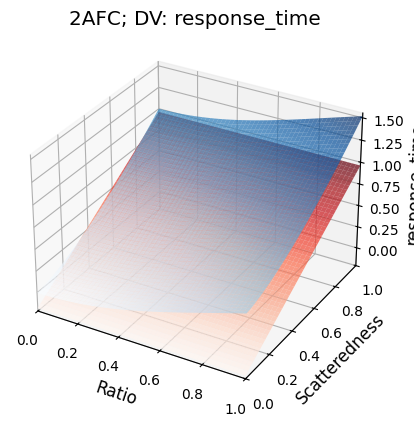

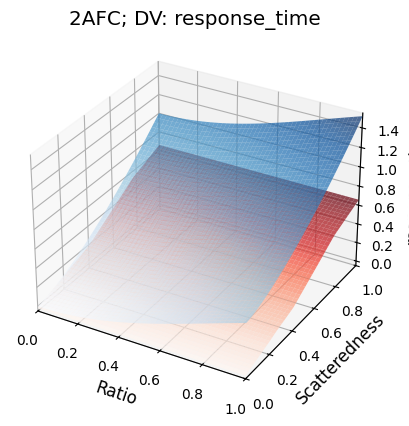

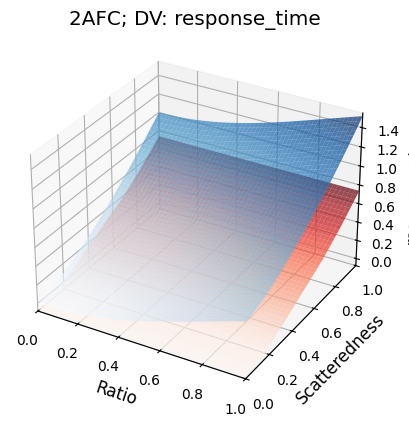

In [ ]:
# Start the closed-loop experimentation loop
for cycle in range(25):
    if cycle == 0:
      # in cycle 0 the initially sampled conditions are used -- these are equal for both experimentalists and have been randomly sampled
      state_loss_based_rf = initial_state_loss_based_rf
      state_loss_based_mlp = initial_state_loss_based_mlp
      state_random = initial_state_random

    else:
      # In every cycle > 0 new experimental conditions are sampled using the respective sampling method
      state_loss_based_rf = experimentalist_state_loss_based_rf(state_loss_based_rf, num_samples=1, random_state=42+cycle, sample_all=[])
      state_loss_based_mlp = experimentalist_state_loss_based_mlp(state_loss_based_mlp, num_samples=1, random_state=42+cycle, sample_all=[])
      state_random = experimentalist_state_random(state_random, num_samples=1, random_state=42+cycle, sample_all=[])

    # Run the experiment for the new conditions (simulate observations)
    state_loss_based_rf = experiment_state(state_loss_based_rf, added_noise=noise_level, random_state=42+cycle)
    state_loss_based_mlp = experiment_state(state_loss_based_mlp, added_noise=noise_level, random_state=42+cycle)
    state_random = experiment_state(state_random, added_noise=noise_level, random_state=42+cycle)

    # Update the model (theorist) based on the newly acquired data
    state_loss_based_rf = theorist_state_loss_based_rf(state_loss_based_rf)
    state_loss_based_mlp = theorist_state_loss_based_mlp(state_loss_based_mlp)
    state_random = theorist_state_random(state_random)

# Finally, plot the resulting model (using the experiment’s plotter)
experiment.plotter(state_loss_based_rf.models[0])
experiment.plotter(state_loss_based_mlp.models[0])
experiment.plotter(state_random.models[0])

# Results and Comparison

Lastly, we evaluate the performance of the three different experimentalists (Random sampler, loss-based sampler using a RF Regressor, and loss-based sampler using a MLP Regressor) by means of comparison based on the mean training loss over the iterations. Further, we look into the performance of the two prediction models (RF Regressor and MLP Regressor) of the loss-based approaches in more detail.

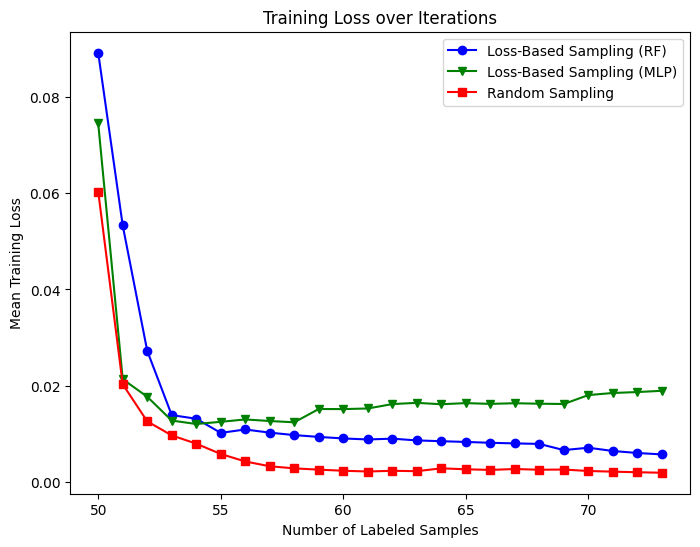

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(n_samples_list, mean_train_loss_list, marker="o", linestyle="-", color="blue", label='Loss-Based Sampling (RF)')
plt.plot(n_samples_list_mlp, mean_train_loss_list_mlp, marker="v", linestyle="-", color="green", label='Loss-Based Sampling (MLP)')
plt.plot(n_samples_list_random, mean_train_loss_list_random, marker='s', linestyle='-', color='red', label='Random Sampling')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Mean Training Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()


**Figure 1:**

This plot shows how the mean training loss evolves over the number of labelled samples for the three different sampling methods:

Loss-Based Sampling (RF) (blue line) uses a Random Forest Regressor to predict the most informative samples.
Loss-Based Sampling (MLP) (green line) employs a Multi-Layer Perceptron (MLP) as the loss predictor.
Random Sampling (red line) selects new samples purely at random.

As can be seen in the figure above, all three experimentalists showcase a similar trend of starting out around a mean training loss of 0.06 to 0.09, which becomes smaller with each new labelled sample. More specifically, the random sampler starts out with the lowest mean training loss and consistently, but marginally, outperforms both loss-based sampling methods. Further, while the loss-based sampler using a MLP Regressor performs slightly better after the initial training, the loss-based sampler using a RF regressor ultimately converges more robustly and performs consistently better after only an additional five labelled samples. Interestingly, all three sampling approaches seem to perform well overall and result in relatively low mean training losses, even though trained on a small dataset only.

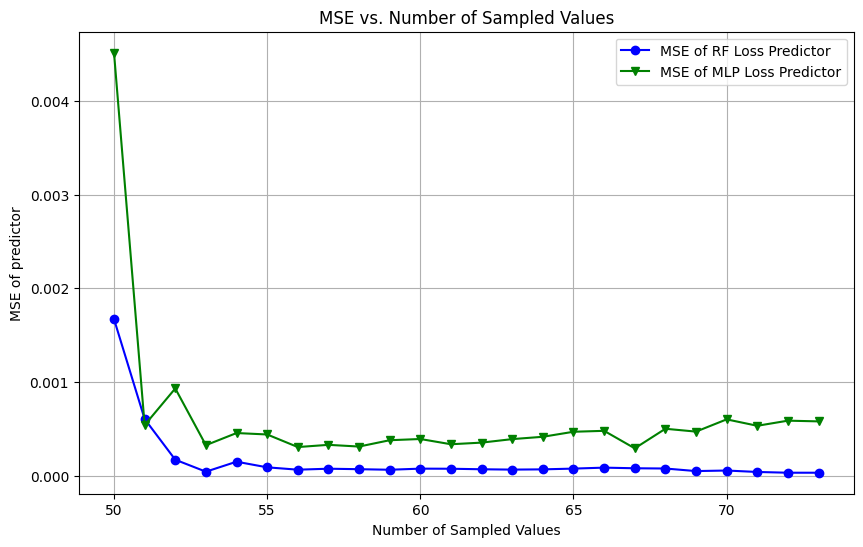

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_samples_list, mse_list, marker='o', linestyle='-', color='b', label='MSE of RF Loss Predictor')
plt.plot(n_samples_list_mlp, mse_list_mlp, marker='v', linestyle='-', color='g', label='MSE of MLP Loss Predictor')
plt.xlabel('Number of Sampled Values')
plt.ylabel('MSE of predictor')
plt.title('MSE vs. Number of Sampled Values')
plt.legend()
plt.grid(True)
plt.show()

**Figure 2:**

This plot compared the Mean Squared Error (MSE) of the two loss prediction models -- the RF and the MLP Regressor --  over the number of sampled values.

As can be seen in Figure 2 and within the context of both loss-based approaches used here, both the RF and MLP loss estimators follow a similar trend and converge at a similar rate. In more detail, the RF loss predictor consistently outperforms the MLP loss predictor, starting out with a lower MSE after initial training and converging to a relatively lower MSE. It has to be mentioned, however, that the MSE is rather small for both loss predictors.

This is in line with the findings of Figure 1, which showcased a better performance of the loss-based approach using an RF compared to a MLP regressor and indicates that this difference in performance is based on the type of used loss prediction model.

# Conclusion and Discussion

Within the scope of this project, we compared three sampling approaches: uniform random sampling, loss-based sampling using a RF Regressor, and loss-based sampling using a MLP Regressor. More specifically, we implemented each strategy as an experimentalist and subsequently integrated them within an AutoRA closed-loop experiment, using a 2AFC experiment as the experiment runner and a FFN regressor as the theorist. Our findings showcase that while a RF Regressor performs slightly better compared to a MLP Regressor when used as a prediction model within the setting of a loss-based sampling approach, a random sampling approach still was able to outperform both the loss-based strategies.

It is noteworthy that while our RF Regressor demonstrates very low MSEs on training data, this performance may be a sign of overfitting, especially given our small sample size. Furthermore, since our evaluation using the MSE between the predicted and actual loss is restricted to training data, and hence data which has already been seen by the prediction model and the model with the task objective, we cannot definitively assess how well our loss predictors will generalize to unseen data. We chose to evaluate the two regressors on training data rather than on a separate held-out test data, as we wanted to make use of all available datapoints for training purposes and not lose any for testing only -- or in other words, in evaluating the two implemented prediction models, we prioritised sample-efficiency over cross-validation.

Interestingly, the computational costs associated with loss-based sampling are in general thought to be considerably higher compared to random sampling methods. Therefore, it should be carefully evaluated whether the potential benefits of a loss-based approach justify the resource expenditures. Within the framework of a 2AFC task here, and considering our previous findings, a random sampling strategy seems to be the preferred sampling method, as it not only shows better performance, but also is associated with lower computational costs.

Lastly, it is worth mentioning that the paper, based on which the two loss-based approaches were created here, implemented their sampling strategies within the context of classification tasks. Given that we applied the approach on an experiment with continuous experimental conditions and observations, this required some modifications like the evaluation on MSE rather than on an average cross-entropy loss, for example. This might be a reason why the two loss-based approaches were not able to outperform random sampling in this case. However, given that Haimovich et al. (2024) further made use of an adaptive step-size which achieves stochastic Polyak’s step size in
expectation within the context of their proposed adaptive-weight sampling approach, this additional factor might be relevant in outperforming a random sampling strategy, as has been demonstrated in their experiments. While beyond the scope of this project, this additional step would be interesting for future investigation and comparison to three approaches implemented and evaluated within the context of this project.



# References

- Haimovich, D., Karamshuk, D., Linder, F., Tax, N., & Vojnovic, M. (2024). On the convergence of loss and uncertainty-based active learning algorithms. ArXiv, abs/2312.13927. (https://github.com/facebookresearch/AdaptiveWeightSampling)